<a href="https://colab.research.google.com/github/xanasa14/MLImplementations/blob/master/ToxicComments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re
import nltk 

import matplotlib.pyplot as plt

In [55]:
#toxic_comments = pd.read_csv("/content/train.csv",engine='python',encoding='utf-8')
toxic_comments = pd.read_csv("/content/drive/MyDrive/toxicCommentz/train.csv")

print(toxic_comments.head())

print(toxic_comments.tail)

                 id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]
<bound method NDFrame.tail of                       id  ... identity_hate
0       0000997932d777bf  ...             0
1       000103f0d9cfb60f  ...             0
2       000113f07ec002fd  ...             0
3       0001b41b1c6bb37e  ...             0
4       0001d958c54c6e35  ...             0
...                  ...  ...           ...
159566  ffe987279560d7ff  ...             0
159567  ffea4adeee384e90  ...             0
159568  ffee36eab5c267c9  ...             0
159569  fff125370e4aaaf3  ...             0
159570  fff46fc426af1f9a  ...             0

[159571 rows x 8 columns]>


In [56]:
print(toxic_comments['comment_text'].head())
print(toxic_comments.shape)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object
(159571, 8)


In [57]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()
print(toxic_comments["comment_text"][168])


You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [58]:
counter = 0
offensive = []
nonOffensive = []
for i in range(len(toxic_comments)):
  #if (i <= 500):
  if (int(toxic_comments["toxic"][i]) == 1 or int(toxic_comments["severe_toxic"][i]) == 1 or 
      int(toxic_comments["obscene"][i]) == 1 or int(toxic_comments["threat"][i]) == 1 or
      int(toxic_comments["insult"][i]) == 1 or int(toxic_comments["identity_hate"][i]) == 1):
    #print("Toxic:" + str(toxic_comments["toxic"][i]))
    #print("Severe_toxic:" + str(toxic_comments["severe_toxic"][i]))
    #print("Obscene:" + str(toxic_comments["obscene"][i]))
    #print("Threat:" + str(toxic_comments["threat"][i]))
    #print("Insult:" + str(toxic_comments["insult"][i]))
    #print("Identity_hate:" + str(toxic_comments["identity_hate"][i]))
    offensive.append(1)
    nonOffensive.append(0)
  else: 
    nonOffensive.append(1)
    offensive.append(0)

# Declare a list that is to be converted into a column 

  
# Using 'Address' as the column name 
# and equating it to the list 
toxic_comments['offensive'] = offensive
toxic_comments['nonOffensive'] = nonOffensive


#toxic_comments = toxic_comments[toxic_comments.offensive == 1]


In [59]:
print("comment_text:" + str(toxic_comments["comment_text"][0]))

print("Toxic:" + str(toxic_comments["toxic"][0]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][0]))
print("Obscene:" + str(toxic_comments["obscene"][0]))
print("Threat:" + str(toxic_comments["threat"][0]))
print("Insult:" + str(toxic_comments["insult"][0]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][0]))


len(toxic_comments)
print("Offensive :" + str (toxic_comments['offensive'][0]))
print("Non-offensive :" + str (toxic_comments['nonOffensive'][0]))

comment_text:Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Toxic:0
Severe_toxic:0
Obscene:0
Threat:0
Insult:0
Identity_hate:0
Offensive :0
Non-offensive :1


In [60]:
#toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels = toxic_comments[["offensive", "nonOffensive"]]

toxic_comments_OffensiveOrNot = toxic_comments[["comment_text","offensive", "nonOffensive"]]
print(toxic_comments_OffensiveOrNot["offensive"][168])
print(toxic_comments_OffensiveOrNot["comment_text"][168])

1
You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


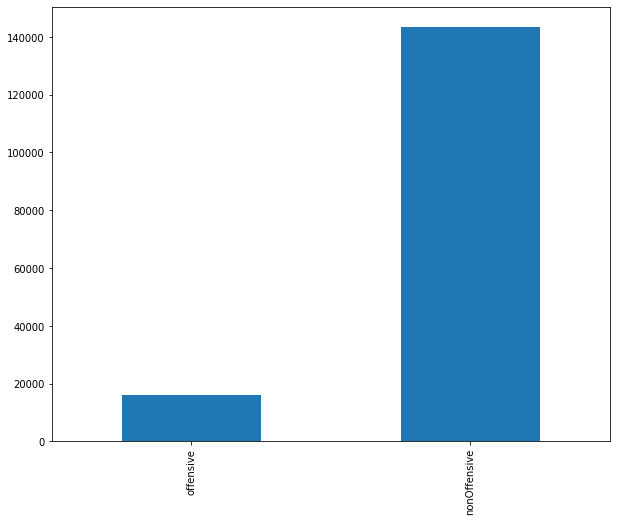

In [61]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

In [62]:
%%time
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

def lemma_traincorpus(text):
    lemm_words = " ".join([lemm.lemmatize(word) for word in text.split()])    
    return lemm_words
                        


toxic_comments_OffensiveOrNot['comment_text']=toxic_comments_OffensiveOrNot['comment_text'].apply(lambda z: lemma_traincorpus(z))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
CPU times: user 34.5 s, sys: 382 ms, total: 34.9 s
Wall time: 35.2 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [10]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [11]:
X = []
#toxic_comments_labels = toxic_comments[["offensive"]]

sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [13]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

#glove_file = open('/content/drive/My Drive/Colab Datasets/glove.6B.100d.txt', encoding="utf8")
glove_file = open('/content/drive/MyDrive/gloves/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [15]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(2, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [16]:
print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          12592400  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 12,709,906
Trainable params: 117,506
Non-trainable params: 12,592,400
_________________________________________________________________
None


In [18]:
history = model.fit(X_train, y_train, batch_size=128, epochs=7, verbose=1, validation_split=0.4)

449/449 [==============================] - 285s 635ms/step - loss: 0.3185 - acc: 0.9022 - val_loss: 0.3286 - val_acc: 0.8977


In [19]:
score = history.model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1995/1995 [==============================] - 90s 45ms/step - loss: 0.3269 - acc: 0.8984
Test Score: 0.3268975615501404
Test Accuracy: 0.8984473943710327


In [20]:

print(X_test.shape)
print(y_test.shape)

print(score)
toxic_comments_labels.values



(63829, 200)
(63829, 2)
[0.3268975615501404, 0.8984473943710327]


array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [21]:
history.model.predict

<bound method Model.predict of <tensorflow.python.keras.engine.functional.Functional object at 0x7fca7bcbffd0>>

In [22]:
model.save('/content/drive/MyDrive/toxicCommentz/my_model.h5')
# LOAD 
import keras
model = keras.models.load_model('/content/drive/MyDrive/toxicCommentz/my_model.h5')



In [23]:
y_pred = history.model.predict(X_test)
print(y_pred)
print(y_test)
print(y_pred.shape)
print(y_test.shape)

[[0.0967657  0.90926224]
 [0.0967657  0.9092623 ]
 [0.09676573 0.90926224]
 ...
 [0.0967657  0.90926224]
 [0.04313827 0.9637737 ]
 [0.09676564 0.9092623 ]]
[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [0 1]
 [0 1]]
(63829, 2)
(63829, 2)


In [24]:
print(len(y_pred))
print(len(y_test))

63829
63829


In [48]:


import sklearn.metrics as metrics
from sklearn.metrics import classification_report
target_names= ["Offensive" , "NonOffensive"]
print(classification_report(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1), target_names=target_names))


matrix = metrics.confusion_matrix(y_pred.argmax(axis=1), y_test.argmax(axis=1),)


              precision    recall  f1-score   support

   Offensive       0.01      0.90      0.02        80
NonOffensive       1.00      0.90      0.95     63749

    accuracy                           0.90     63829
   macro avg       0.51      0.90      0.48     63829
weighted avg       1.00      0.90      0.95     63829



In [49]:
matrix

array([[   72,     8],
       [ 6474, 57275]])

In [50]:
print(y_pred.shape)
y_pred2 = y_pred
y_test2 = y_test

Size = len (y_test2)

y_test2 = y_test2.reshape((Size,-1))
y_pred2 = y_pred2.reshape((Size,-1))


print(y_pred2.shape)
print(y_test2.shape)

matrix = metrics.confusion_matrix(y_pred2.argmax(axis=1), y_test2.argmax(axis=1))


(63829, 2)
(63829, 2)
(63829, 2)


In [51]:
matrix

array([[   72,     8],
       [ 6474, 57275]])

In [52]:
CR = metrics.accuracy_score(y_pred2.argmax(axis=1), y_test2.argmax(axis=1))
print(CR)

0.8984474141847749


In [52]:
             precision    recall  f1-score   support

   Offensive       0.01      0.90      0.02        80
NonOffensive       1.00      0.90      0.95     63749

    accuracy                           0.90     63829
   macro avg       0.51      0.90      0.48     63829
weighted avg       1.00      0.90      0.95     63829


0.8984474141847749
array([[   72,     8],
       [ 6474, 57275]])